# BERT

[![image-1.png](https://i.postimg.cc/PJd3pdbG/image-1.png)](https://postimg.cc/HcP4FDP3)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;"> Идентификация токсичных комментариев</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Интернет-магазин «Викишоп».
    
__Постановка задачи:__ Необходимо разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики качества F1 должно быть не меньше 0.75.
    
__Описание данных:__ Размеченные комментарии. 
    
- `text` - текст комментария
- `toxic` — целевой признак
    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# константы
RANDOM_SEED = 42

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/denismuhanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [21]:
# загрузка данных:
try:
    df = pd.read_csv('data/toxic_comments.csv', index_col='Unnamed: 0')
    display(df.head(2))
except:
    display('Данные не доступны')

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [22]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

__Проверим пропуски в данных:__

In [23]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [24]:
print(f'Общее количество дубликатов в данных: {df.index.duplicated().sum()}')

Общее количество дубликатов в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
- Дублитакы в данных отсутствуют.

</div>

__Баланс целевого признака__

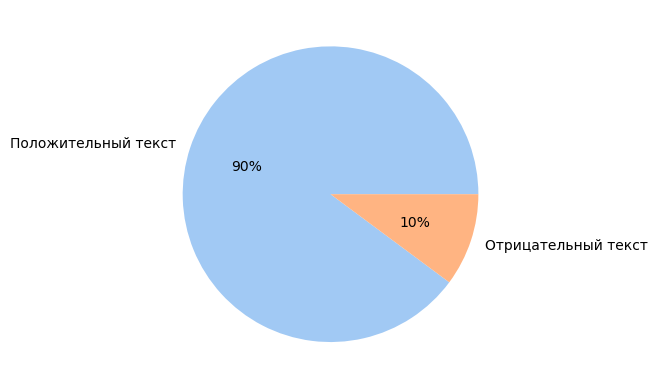

In [25]:
# баланс целевого признака
data = [df['toxic'].value_counts()[0], df['toxic'].value_counts()[1]]
labels = ['Положительный текст', 'Отрицательный текст']

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

- Присутствует дисдаланс классов в целевоц переменной, это надо учесть при обучении моделей.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Обработка и анализ данных
    
</div>

### Распределение количества символов в комментариях

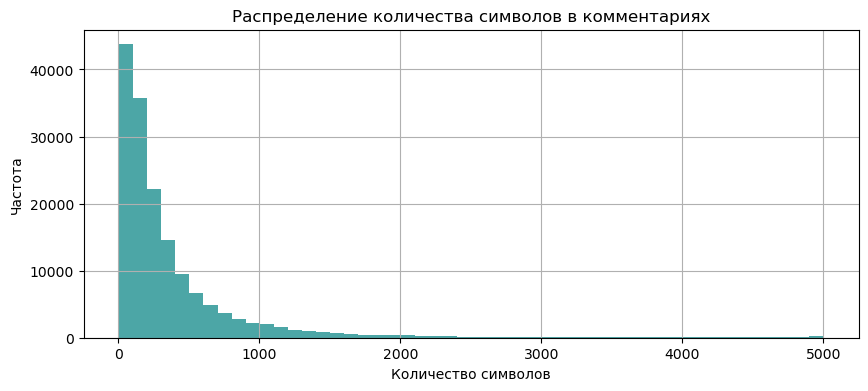

In [26]:
# рассчет количество символов в каждом комментарии
df['char_count'] = df['text'].apply(len)

# визуализация
plt.figure(figsize=(10, 4))
plt.hist(df['char_count'], bins=50, color='teal', alpha=0.7)
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title('Распределение количества символов в комментариях')
plt.grid(True)
plt.show()

- Как видно из графика некоторые коментарии достаточно длинные, посмотрим на некотые:

In [27]:
# настройка 
pd.set_option("display.max_colwidth", 500)
display(df[df['char_count']==5000].sample(2))

,text,toxic,char_count
57124,Fuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ancestryFuck-off-Jewish ...,1,5000
9664,"FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHEIS...",1,5000


- Наблюдаем повторение одних и тех же фраз, частично данную проблему можно решить регулярными выражениями

__Очистка текста__

Очистим текст от небывквенных символов и части дублируемых подстрок

In [28]:
def clean_text(text):
    # перевод в нижний регист
    text = text.lower()
    # поиск и удаление повторяющихся подстрок
    text = re.sub(r'(.{3,})(\1{2,})', r'\1', text)
    # заменяем все символы пунктуации на пробелы
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"[\d\n]", " ", text)
    # удаление символов, которые не находятся в диапазоне ASCII 
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # разделяем все слова и объединяем с единичным пробелом
    text = " ".join(text.split())

    return text

In [29]:
df['text'] = df['text'].apply(clean_text)

__Частотность слов__

In [30]:
# токенизация текста
df['tokens'] = df['text'].apply(lambda x: x.split())

In [31]:
# список всех токенов
tokens_list = [item for sublist in df['tokens'].to_list() for item in sublist]

# частотность токенов
freq_dist = FreqDist(tokens_list)
freq_dist

FreqDist({'the': 494179, 'to': 296140, 'i': 235653, 'of': 223259, 'and': 223022, 'a': 214055, 'you': 211396, 'is': 174562, 'that': 160298, 'it': 148011, ...})

In [32]:
# перевод частотности в датафрейм
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['freq'])
display(freq_df)

,freq
explanation,1768
why,17622
the,494179
edits,9888
made,9648
...,...
webaddress,1
gratest,1
hanumakonda,1
automakers,1


- Посмотрим наиболее редкие значения

In [33]:
freq_df[freq_df['freq'] < 10]

,freq
good_article_nominations,1
shirvington,1
dulithgow,3
wonju,4
talibans,7
...,...
webaddress,1
gratest,1
hanumakonda,1
automakers,1


- Можно увидеть, что в тексте присутствует так же нижнии подчеркивания, посмотрим текст где используются данные символы:

In [34]:
pd.set_option("display.max_colwidth", 500)
df[df.text.str.contains('_')][['text']]

,text
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay u...
33,i was able to post the above list so quickly because i already had it in a text file in my hard drive i ve been meaning to get around to updating the sound list for some time now as far as generating interest i ve spent four years trying to drum up more interest in freely licensed full length classical music unfortunately my attempts failed i m still effectively the only one who does it the classical music wikiproject was not interested wikipedia_talk wikiproject_classical_music archive_ nee...
34,well not before the process but before how we do things with subpages his rfa is listed on noseptember s page and you can find it if you look september i think i have my differences with el_c to be sure but was surprised to see a block so i left a note t c
91,transliteration of russian place names in writing about moscow metro for the malayalam wikipedia we are finding it difficult to correctly transliterate the russian place names for example do we pronounce park kultury as paark kalttari or paark kalchchari or perhaps something completely different can somebody please help by transliterating the list given in https ml wikipedia org wiki _ i am not putting the list here as i don t want to clutter up this page thanks
95,thanks i can see that violating clearly stated wikipedia policy is no problem with some people as is now being reviewed elsewhere finishing up one other wiki project todsy and then spending the rest of the day on an important personal blog entry then i ll go find other discussions of james petras fascinating discussion of the use of the term jewish lobby so that i don t have to put back up the deleted dissident voice article right away per talk jewish_lobby wp v_ _comparing_jewish_virtual_li...
...,...
159197,atomic er user atomic er since i own all copyrights to the gas theory and gravitation and any and all works by me and you previously rejected these works i now prohibit you from posting any mention of these works other than that which i myself have posted you rejected my copyright yet i own those pages in question i am not and was not offended however i deny wikipedia as a credible source i have encouraged google to produce encylopediactionary all the worlds encyclopedias and dictionaries in...
159224,jprw please visit this link to better understand how wikipedia works http en wikipedia org wiki wikipedia biographies_of_living_persons
159255,hello i keep getting a message from another user stating that i am vandalizing a page which clearly am not please go to http en wikipedia org wiki talk nissan_gt r under overwhelmingly published articles state the nissan gtr is a supercar what have i done wrong and why are they not following the rules set forth by wikipeadia please help thank you
159297,news suppressed on wikipedia http rexcurry net wikipedialies html rexcurry net is the historian who made the following discoveries covered elsewhere and on wikipedia the usa s first pledge used a straight arm salute and it was the origin of the salute of the monstrous national socialist german workers party nazis it was not an ancient roman salute http rexcurry net pledgesalute html the pledge began with a military salute that then stretched outward toward the flag historic photographs are a...


__stopwords/word_tokenize__

In [7]:
import torch
import transformers
from tqdm import notebook

In [88]:
df_sample = df.sample(10000).reset_index(drop=True) 

In [89]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   toxic   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [90]:
# инициализация токенизатора
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

__Проверим длинну текстов__

In [91]:
print(f'Максимальная длинна текста составляет: {max(map(len, df_sample["text"]))} символов')

Максимальная длинна текста составляет: 5000 символов


In [92]:
print(f'Минимальная длинна текста составляет: {min(map(len, df_sample["text"]))} символов')

Минимальная длинна текста составляет: 16 символов


- Стандартная версия модели BERT ('bert-base-cased') имеет ограничение на максимальную длину последовательности, и это ограничение составляет 512 токенов. Это связано с ограниченной памятью графических процессоров (GPU) и вычислительной сложностью обработки более длинных последовательностей при обучении модели.
- Мы можем разделить длинные тексты на более короткие части, учитывая минимальную длинну изначальных текстов, тем самым увеличим датафрейм и стандартизируем данные для правильной работы молели BERT

### Обработка длинных текстов

In [93]:
# максимальная длина последовательности
max_seq_length = 510
# минимальная длина последовательности (5)
min_seq_length = min(map(len, df_sample["text"]))
print(max_seq_length, min_seq_length)

510 16


In [94]:
# список для новых строк
new_rows = []
# функция для разделения
def split(x):
    # разделение на части
    chunks = [' '.join((x['text'][i:i + max_seq_length]).split()[:-1]) for i in range(0, len(x['text']), max_seq_length)]
    # cоздание новых строк для каждой части
    for chunk in chunks:
        if len(chunk) >= min_seq_length:
            new_row = {'text': chunk, 'toxic': x['toxic']}
            new_rows.append(new_row)
            
df_sample.apply(split, axis=1)
print('Список стандартизированных строк готов')

Список стандартизированных строк готов


In [95]:
# создание обновленного датасета и вывод основной информации
df_split_sample = pd.DataFrame(new_rows)
print(df_split_sample.info())
display(df_split_sample.head(2))
print(f'Датасет увеличился на {(len(df_split_sample)-len(df_sample))/len(df_sample):.0%}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13936 entries, 0 to 13935
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13936 non-null  object
 1   toxic   13936 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 217.9+ KB
None


,text,toxic
0,""" The image was marked for deletion as a copyr...",0
1,""" IP block extensions While I completely agree...",0


Датасет увеличился на 39%


In [13]:
# создание обновленного датасета и вывод основной информации
df_split = pd.DataFrame(new_rows)
print(df_split.info())
display(df_split.head(2))
print(f'Датасет увеличился на {(len(df_split)-len(df))/len(df):.0%}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224778 entries, 0 to 224777
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    224778 non-null  object
 1   toxic   224778 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


Датасет увеличился на 41%


### Токенизация

In [96]:
# токенизация данных
tokenized = df_split_sample['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [97]:
len(tokenized)

13936

### Паддинг данных

In [98]:
# максимальная длина среди токенов
max_len = max(map(len, tokenized))
print(f' Максимальная длина среди токенов составляет: {max_len}')

 Максимальная длина среди токенов составляет: 425


In [99]:
# паддинг данных
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized])

# создание маски внимания
attention_mask = np.where(padded != 0, 1, 0)

In [100]:
len(attention_mask)

13936

In [56]:
max(map(len, padded))

272

### Эмбеддинги текста

In [57]:
# загрузка конфигурации
config = transformers.BertConfig.from_pretrained('bert-base-cased')

# загрузка модели
model = transformers.BertModel.from_pretrained('bert-base-cased', config=config)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
import torch
from tqdm.notebook import tqdm

batch_size = 536
embeddings = []

# Переносим модель на Metal Performance Shaders (MPS)
device = torch.device("mps")
model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        

  0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [115]:
len(X)

565

In [59]:
X = np.concatenate(embeddings)


In [22]:
print (torch.backends.mps.is_available()) #macOS выше 12.3+ 
print (torch.backends.mps.is_built()) #MPS активирован

True
True


In [60]:
y = df_split_sample['toxic'].values

In [61]:
len(y)

1370

In [62]:
from sklearn.model_selection import train_test_split



# Создание тренировочного и тестового наборов с сохранением баланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


In [71]:
! pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [76]:
# Подсчет количества классов в y_train
class_counts = Counter(y_train)

# Определение количества примеров для undersampling
minority_class_count = class_counts[1]  # Меньший класс
majority_class_count = class_counts[0]  # Больший класс
desired_majority_class_count = minority_class_count  # Задайте желаемое количество примеров для класса 0

# Создание объекта RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={0: desired_majority_class_count, 1: minority_class_count})

# Применение undersampling к данным
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Проверка новых балансов классов
print(Counter(y_train_resampled))

Counter({0: 101, 1: 101})


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [83]:
mod = LogisticRegression(max_iter=100)

In [84]:
mod.fit(X_train_resampled, y_train_resampled)

/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [85]:
pred = mod.predict(X_test)

In [86]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, pred))

0.8250728862973761


In [87]:
from sklearn.metrics import f1_score
print(f1_score(y_test, pred))

0.47368421052631576


In [31]:
df_sample['toxic'].value_counts()

0    358
1     42
Name: toxic, dtype: int64

In [34]:
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.4 MB/s eta 0:00:00a 0:00:010m


In [35]:
import xgboost as xgb

# Создание объекта DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [37]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss'
}

# Обучение модели
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Предсказания
y_pred = model.predict(dtest)

In [38]:
# Оценка модели по F1
f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.00


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны